# Breast Cancer Detection | Exploratory Data Analysis

In this notebook we analyse our images and metadata to help inform modelling.

### Papers:

 - 

In [23]:
import pandas as pd
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import cv2
import albumentations as A
import imgaug as ia
import imgaug.augmenters as iaa

sys.path.append("..")
from utils.utils import read_images, display_img
from utils.constants import ROWS, COLS, CHANNELS, SEED

plt.rcParams["figure.figsize"] = (12, 6)
pal = sns.color_palette().as_hex() # Color palette

np.random.seed(SEED)
ia.seed(SEED)

In [2]:
# Define directories
base_dir_path = "../"

# Raw paths
data_dir_path = os.path.join(base_dir_path, "data")
data_raw_dir_path = os.path.join(data_dir_path, "raw")
data_raw_train_dir_path = os.path.join(data_raw_dir_path, "train_images")
data_raw_test_dir_path = os.path.join(data_raw_dir_path, "test_images")

# Cleaned paths
data_cleaned_dir_path = os.path.join(data_dir_path, "cleaned")
data_cleaned_train_dir_path = os.path.join(data_dir_path, "train_images")
data_cleaned_test_dir_path = os.path.join(data_dir_path, "test_images")

# List dirs
data_dir = os.listdir(data_dir_path)
data_raw_train_dir = os.listdir(data_raw_train_dir_path)
data_raw_test_dir = os.listdir(data_raw_test_dir_path)

# Sample submission & metadata paths
sample_submission_path = os.path.join(data_dir_path, "sample_submission.csv")
metadata_train_path = os.path.join(data_dir_path, "train.csv")
metadata_test_path = os.path.join(data_dir_path, "test.csv")

# Read in sample sub and metadata
sample_submission = pd.read_csv(sample_submission_path)
metadata_train = pd.read_csv(metadata_train_path)
metadata_test = pd.read_csv(metadata_test_path)

metadata_train.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [3]:
# Print number of train images
print(f"Number of train images: {len(metadata_train)}")

Number of train images: 54706


## Metadata Analysis
There are some features that are provided in the train metadata, but not for the test metadata. These features are listed below.

In [85]:
# Summary stats number of records per patient
print(f"{'-'*100}\nFeature overlap between train and test metadata\n{'-'*100}")
print(list(set(metadata_train.columns) & set(metadata_test.columns)))

----------------------------------------------------------------------------------------------------
Feature overlap between train and test metadata
----------------------------------------------------------------------------------------------------
['laterality', 'view', 'patient_id', 'image_id', 'machine_id', 'age', 'implant', 'site_id']


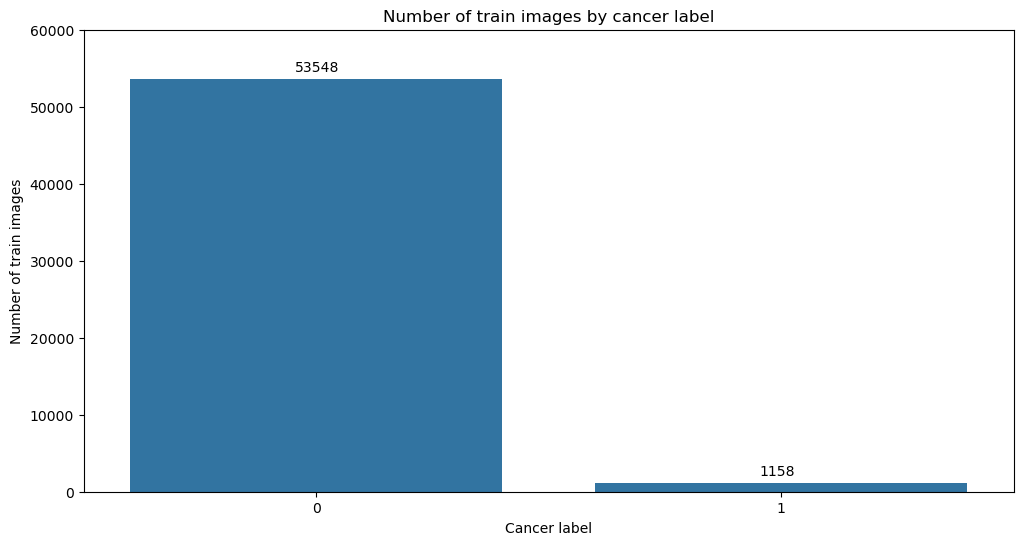

In [26]:
# Number of train images by cancer label
ax = sns.countplot(
    data=metadata_train, 
    x="cancer",
    order=metadata_train["cancer"].value_counts().index,
    color=pal[0]
)

for p, label in zip(ax.patches, metadata_train["cancer"].value_counts()):
    ax.annotate(label, (p.get_x() + 0.354, p.get_height() + 1000.15))

plt.title("Number of train images by cancer label")
plt.xlabel("Cancer label")
plt.ylabel("Number of train images")
plt.ylim([0, 60000])
plt.show()

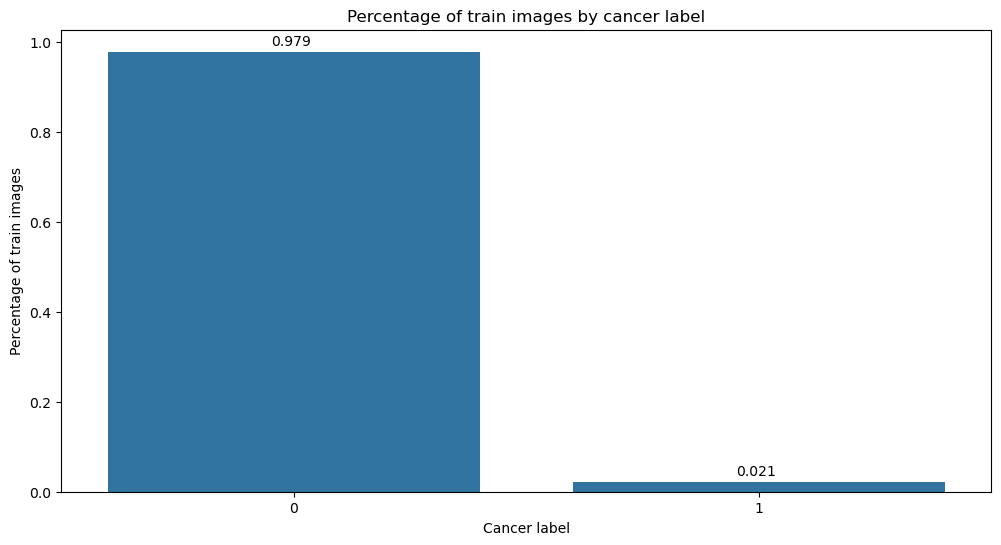

In [27]:
# Percentage of train images by cancer label
ax = sns.barplot(
    data=pd.DataFrame(metadata_train["cancer"].value_counts(normalize=True)) \
        .reset_index() \
        .rename(columns={"cancer": "pct", "index": "cancer"}),
    x="cancer",
    y="pct",
    order=metadata_train["cancer"].value_counts().index,
    color=pal[0]
)

for p, label in zip(ax.patches, round(metadata_train["cancer"].value_counts(normalize=True), 3)):
    ax.annotate(label, (p.get_x() + 0.35, p.get_height() + 0.015))
    
plt.title("Percentage of train images by cancer label")
plt.xlabel("Cancer label")
plt.ylabel("Percentage of train images")
plt.show()

Highly imbalanced data as expected. Resilience to false negatives will be important.

In [6]:
# Print unique site IDs
print(f"There are {metadata_train['site_id'].nunique()} unique site IDs")
print(f"Site IDs: {metadata_train['site_id'].unique()}")

There are 2 unique site IDs
Site IDs: [2 1]


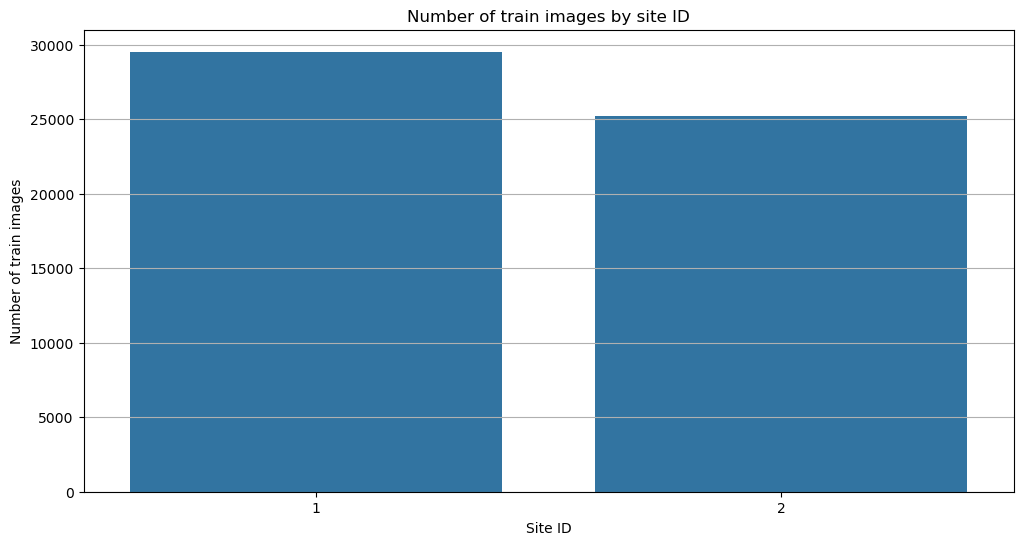

In [37]:
# Number of train images by site ID
sns.barplot(
    data=pd.DataFrame(metadata_train["site_id"].value_counts()) \
        .reset_index() \
        .rename(columns={"site_id": "pct", "index": "site_id"}),
    x="site_id",
    y="pct",
    color=pal[0]
)
    
plt.title("Number of train images by site ID")
plt.xlabel("Site ID")
plt.ylabel("Number of train images")
plt.grid(axis="y")
plt.show()

Number of train records by site ID seems to be split down the middle.

In [58]:
# Percentage of confirmed cancer images by site ID
print(
f"{'-'*100}\nPct of cancer positive images for each site ID (of total number of train \
cancer positive images)\n{'-'*100}"
)
print(metadata_train.groupby("site_id")["cancer"].sum() / metadata_train["cancer"].sum())

----------------------------------------------------------------------------------------------------
Pct of cancer positive images for each site ID (of total number of train cancer positive images)
----------------------------------------------------------------------------------------------------
site_id
1    0.573402
2    0.426598
Name: cancer, dtype: float64


Site 1 has the majority of cancer positive images out of the total number of cancer positive images in the train set, but not by a huge amount.

In [60]:
# Percentage of confirmed cancer images by site ID
print(f"{'-'*100}\nPercentage of cancer positive images (of number of train images) by site ID\n{'-'*100}")
print(metadata_train.groupby("site_id")["cancer"].sum() / metadata_train["site_id"].value_counts())

----------------------------------------------------------------------------------------------------
Percentage of cancer positive images (of number of train images) by site ID
----------------------------------------------------------------------------------------------------
site_id
1    0.022494
2    0.019613
dtype: float64


Site 1 has a slightly higher percentage of cancer positive images out of the number of images for each site ID compared to site 2, but these are more equal (presumably because site 1 in general has a slightly higher number of train images).

In [10]:
# Print unique patient IDs
print(f"There are {metadata_train['patient_id'].nunique()} unique patient IDs")

There are 11913 unique patient IDs


In [62]:
# Summary stats number of records per patient
print(f"{'-'*100}\nSummary stats for number of records per patient\n{'-'*100}")
print(metadata_train["patient_id"].value_counts().describe())

----------------------------------------------------------------------------------------------------
Summary stats for number of records per patient
----------------------------------------------------------------------------------------------------
count    11913.000000
mean         4.592126
std          1.133216
min          4.000000
25%          4.000000
50%          4.000000
75%          5.000000
max         14.000000
Name: patient_id, dtype: float64


An average of 4-5 train images per patient, with a max number of train images for patients being 14. We should pay attention to patient ID when conducting cross validation, splitting using patient ID as a group to avoid data leakage. 

In [63]:
# Number of unique patients by site ID
print(f"{'-'*100}\nNumber of unique patient IDs by site ID\n{'-'*100}")
print(metadata_train.groupby("site_id")["patient_id"].nunique())

----------------------------------------------------------------------------------------------------
Number of unique patient IDs by site ID
----------------------------------------------------------------------------------------------------
site_id
1    5818
2    6095
Name: patient_id, dtype: int64


Site ID is pretty much split down the middle in terms of how many unique patients have had imaging completed there.

In [64]:
# Number of unique site IDs by patient ID
print(f"{'-'*100}\nSummary stats for number of unique site IDs by patient ID\n{'-'*100}")
print(metadata_train.groupby("patient_id")["site_id"].nunique().describe())

----------------------------------------------------------------------------------------------------
Summary stats for number of unique site IDs by patient ID
----------------------------------------------------------------------------------------------------
count    11913.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: site_id, dtype: float64


No patient has had imaging done in both site IDs, based on the unique patient IDs. Site ID therefore seems to be not helpful, unless there are differences in imaging techniques. If there are visible differences in imaging for site IDs, we'll have to consider this during cross validation. Let's look into that later.

In [14]:
# Print unique laterality
print(f"There are {metadata_train['laterality'].nunique()} unique laterality values")
print(f"Laterality values: {metadata_train['laterality'].unique()}")

There are 2 unique laterality values
Laterality values: ['L' 'R']


In [65]:
# Summary stats for number of unique laterality values per patient
print(f"{'-'*100}\nSummary stats for number of unique laterality values per patient ID\n{'-'*100}")
print(metadata_train.groupby('patient_id')['laterality'].nunique().describe())

----------------------------------------------------------------------------------------------------
Summary stats for number of unique laterality values per patient ID
----------------------------------------------------------------------------------------------------
count    11913.0
mean         2.0
std          0.0
min          2.0
25%          2.0
50%          2.0
75%          2.0
max          2.0
Name: laterality, dtype: float64


In [66]:
# Number of train images by laterality
print(f"{'-'*100}\nNumber of train images by laterality\n{'-'*100}")
print(metadata_train["laterality"].value_counts())

----------------------------------------------------------------------------------------------------
Number of train images by laterality
----------------------------------------------------------------------------------------------------
R    27439
L    27267
Name: laterality, dtype: int64


In [17]:
# Number of unique view values
print(f"There are {metadata_train['view'].nunique()} unique view values")

There are 6 unique view values


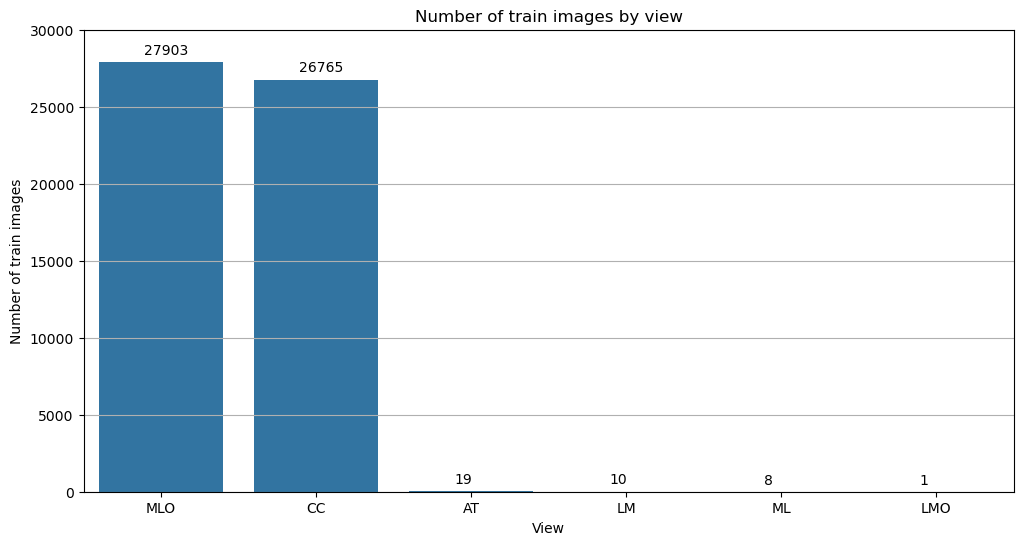

In [38]:
# Number of train images by cancer label
ax = sns.countplot(
    data=metadata_train, 
    x="view",
    order=metadata_train["view"].value_counts().index,
    color=pal[0]
)

for p, label in zip(ax.patches, metadata_train["view"].value_counts()):
    ax.annotate(label, (p.get_x() + 0.29, p.get_height() + 500.15))

plt.title("Number of train images by view")
plt.xlabel("View")
plt.ylabel("Number of train images")
plt.ylim([0, 30000])
plt.grid(axis="y")
plt.show()

The majority of scans come from the `MLO` and `CC` views. Other views `AT`, `LM`, `ML` and `LMO` amount to 38 train images together.

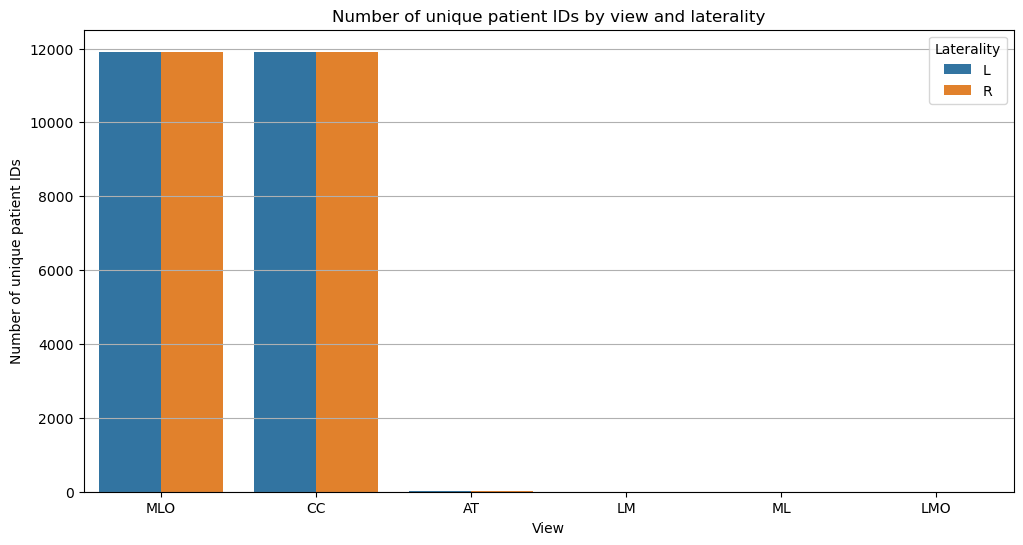

In [72]:
# Number of unique patients by view and laterality
ax = sns.barplot(
    data=pd.DataFrame(metadata_train.groupby(["view", "laterality"])["patient_id"].nunique()).reset_index(),
    x="view",
    y="patient_id",
    hue="laterality",
    order=metadata_train["view"].value_counts().index
)
    
plt.title("Number of unique patient IDs by view and laterality")
plt.xlabel("View")
plt.ylabel("Number of unique patient IDs")
plt.legend(loc="upper right", title="Laterality")
plt.grid(axis="y")
plt.show()

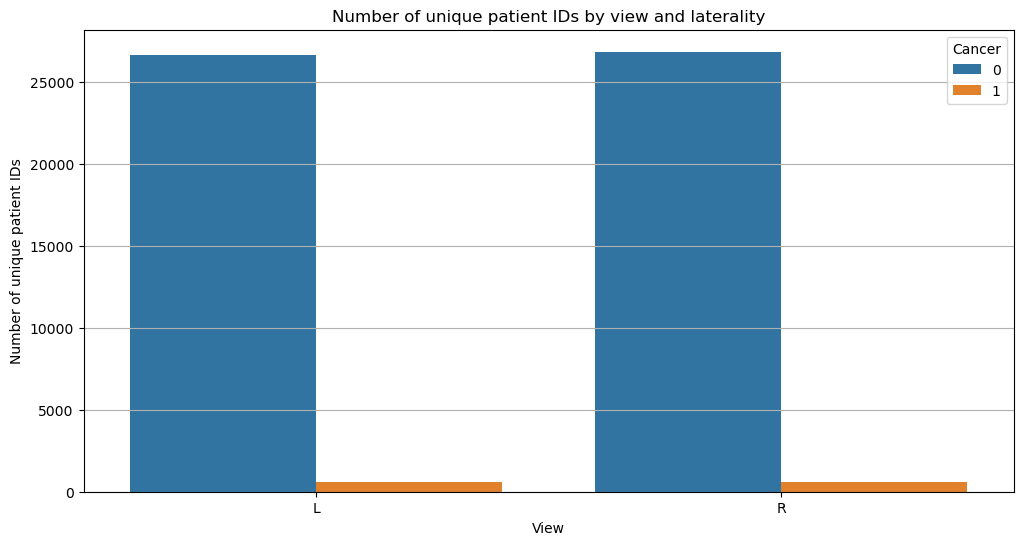

In [71]:
# Number of train images by cancer label and laterality
ax = sns.barplot(
    data=pd.DataFrame(metadata_train.groupby(["laterality", "cancer"])["patient_id"].count()).reset_index(),
    x="laterality",
    y="patient_id",
    hue="cancer"
)
    
plt.title("Number of train images by laterality and cancer label")
plt.xlabel("Laterality")
plt.ylabel("Number of train images")
plt.legend(loc="upper right", title="Cancer")
plt.grid(axis="y")
plt.show()

The number of cancer positive images seem consistent across laterality. View continues to appear to be a not very useful feature, based on the metadata. This will need to be checked against the images themselves, like for site ID.

In [87]:
# Print unique machine_id
print(f"There are {metadata_train['machine_id'].nunique()} unique machine IDs")

There are 10 unique machine IDs


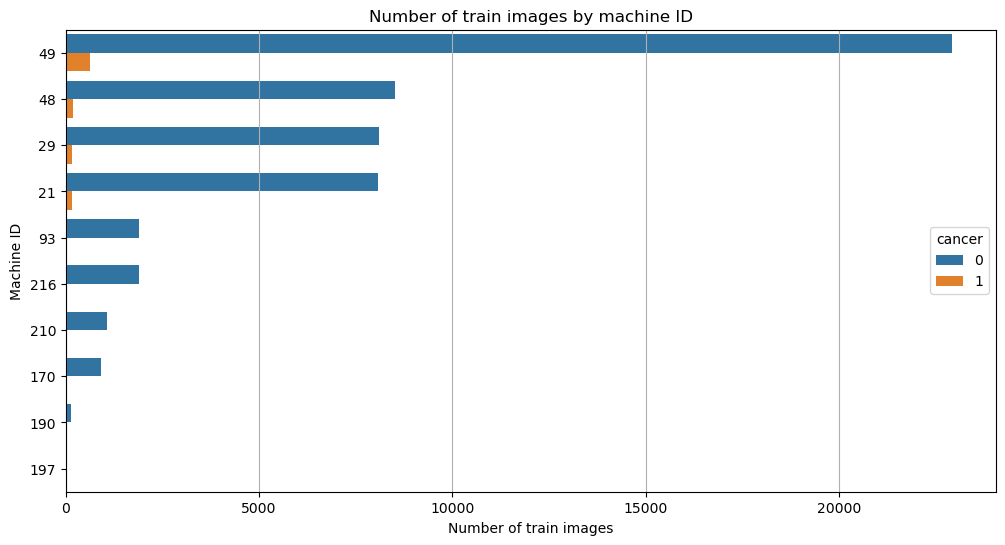

In [127]:
# Number of train images by machine ID and cancer label
ax = sns.countplot(
    data=metadata_train, 
    y="machine_id",
    order=metadata_train["machine_id"].value_counts().index,
    hue="cancer"
)

plt.title("Number of train images by machine ID and cancer label")
plt.xlabel("Number of train images")
plt.ylabel("Machine ID")
plt.grid(axis="x")
plt.show()

There's quite a large variance for number of train images by machine ID. We should definitely assess the difference in imaging for each machine ID, as we want to make sure there is no data leakage.

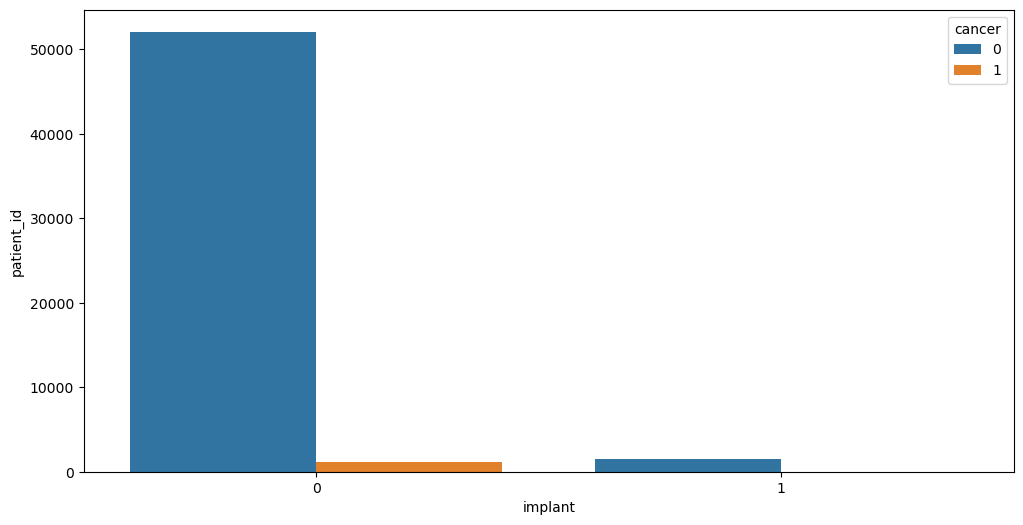

In [133]:
# Number of train images by cancer label and implant status
ax = sns.barplot(
    data=pd.DataFrame(metadata_train.groupby(["implant", "cancer"])["patient_id"].count()).reset_index(),
    x="implant",
    y="patient_id",
    hue="cancer"
)
    
plt.title("Number of train images by laterality and cancer label")
plt.xlabel("Laterality")
plt.ylabel("Number of train images")
plt.legend(loc="upper right", title="Cancer")
plt.grid(axis="y")
plt.show()

In [152]:
# Number of cancer positive images by implant status
print(f"{'-'*100}\nNumber of cancer positive train images by implant status\n{'-'*100}")
print(metadata_train.groupby(['implant'])['cancer'].sum())

----------------------------------------------------------------------------------------------------
Number of cancer positive train images by implant status
----------------------------------------------------------------------------------------------------
implant
0    1145
1      13
Name: cancer, dtype: int64


There are very few train images with a positive implant status. This may be more important information alongside images, as images may have subtle differences that are not neccessarily relevant to cancer status.

In [86]:
metadata_train

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0            2       10006   462822612          L   CC  61.0       0       0   
1            2       10006  1459541791          L  MLO  61.0       0       0   
2            2       10006  1864590858          R  MLO  61.0       0       0   
3            2       10006  1874946579          R   CC  61.0       0       0   
4            2       10011   220375232          L   CC  55.0       0       0   
...        ...         ...         ...        ...  ...   ...     ...     ...   
54701        1        9973  1729524723          R  MLO  43.0       0       0   
54702        1        9989    63473691          L  MLO  60.0       0       0   
54703        1        9989  1078943060          L   CC  60.0       0       0   
54704        1        9989   398038886          R  MLO  60.0       0       0   
54705        1        9989   439796429          R   CC  60.0       0       0   

       invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0             0     NaN        0     NaN          29                    False  
1             0     NaN        0     NaN          29                    False  
2             0     NaN        0     NaN          29                    False  
3             0     NaN        0     NaN          29                    False  
4             0     0.0        0     NaN          21                     True  
...         ...     ...      ...     ...         ...                      ...  
54701         0     1.0        0       C          49                    False  
54702         0     NaN        0       C         216                    False  
54703         0     NaN        0       C         216                    False  
54704         0     0.0        0       C         216                     True  
54705         0     0.0        0       C         216                     True  

[54706 rows x 14 columns]

In [5]:
img_array = read_images(
    data_dir_path=data_cleaned_dir_path, # Set to cleaned dir as not writing images
    rows=ROWS, 
    cols=COLS, 
    channels=CHANNELS, 
    write_images=False, 
    output_data_dir_path=data_cleaned_dir_path
)
print(f"Image array shape: {img_array.shape}")

Reading images from: ../data/cleaned
Rows set to 1024
Columns set to 1024
Channels set to 3
Writing images is set to: False
Reading images...


0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 51/51 [00:11<00:00,  4.55it/s]


Image reading complete.
Image array shape: (333, 1024, 1024, 3)
Image array shape: (333, 1024, 1024, 3)


### Image Channels

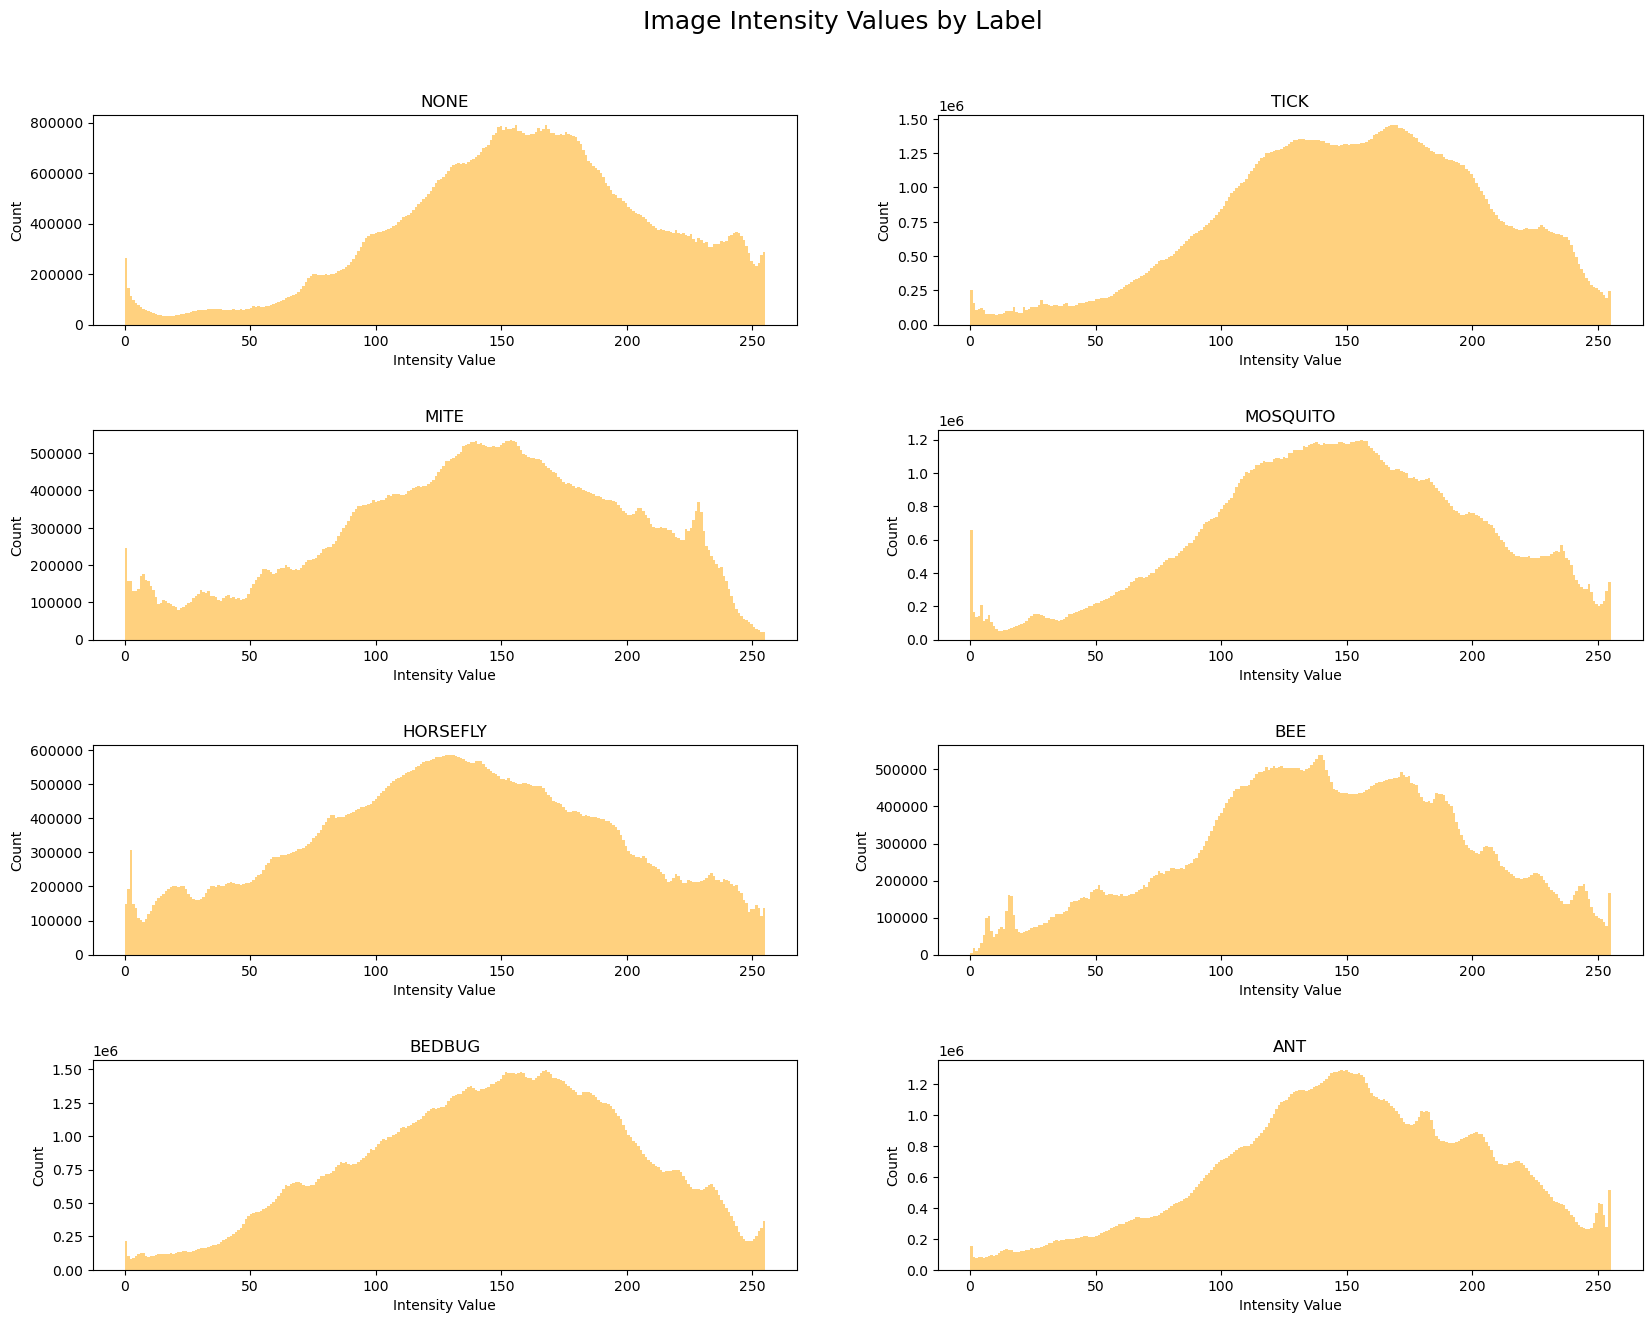

In [6]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals = np.append(img_vals, img_array_subset[idx].ravel())

    ax.hist(img_vals, bins = 256, color = "orange", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

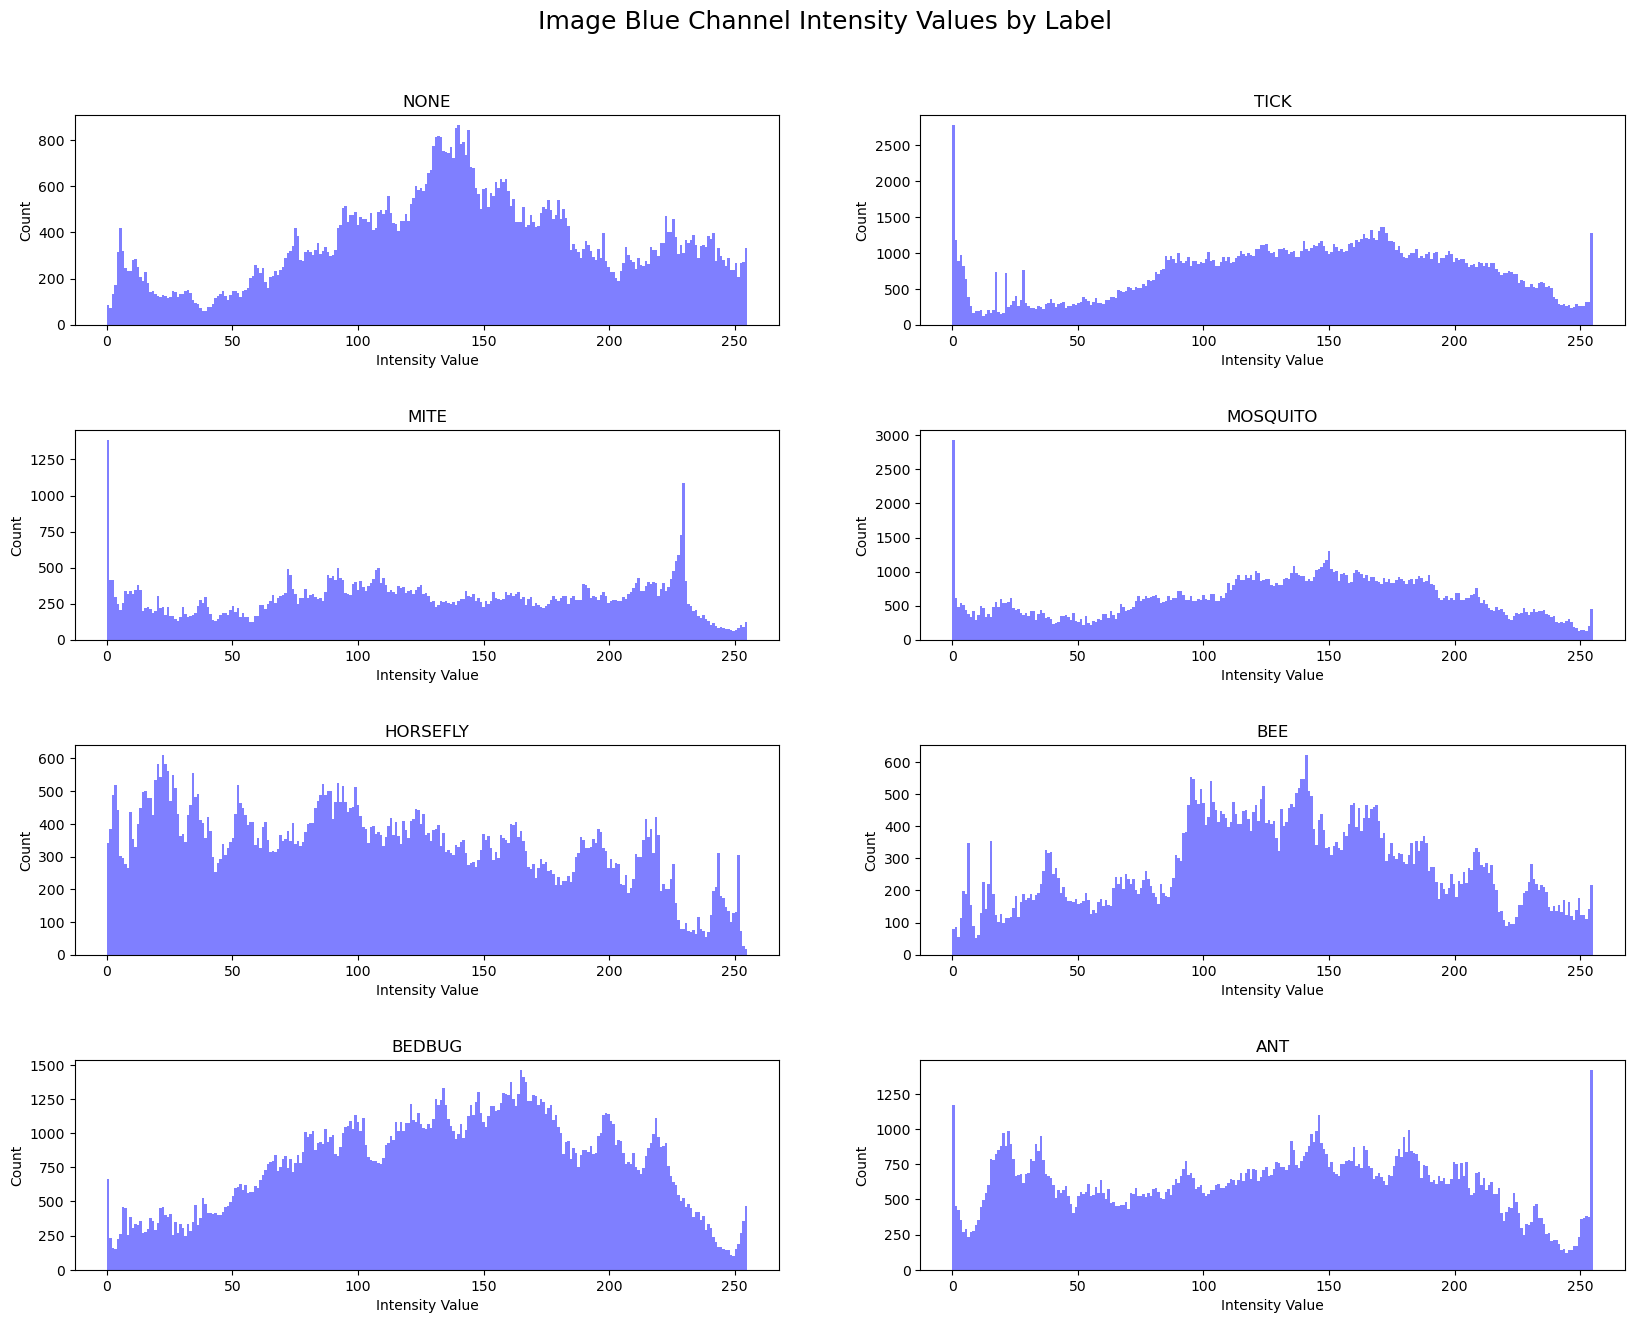

In [7]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Blue Channel Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals_b = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals_b = np.append(img_vals_b, img_array_subset[idx, :, 0].ravel())

    ax.hist(img_vals_b, bins=256, color="blue", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

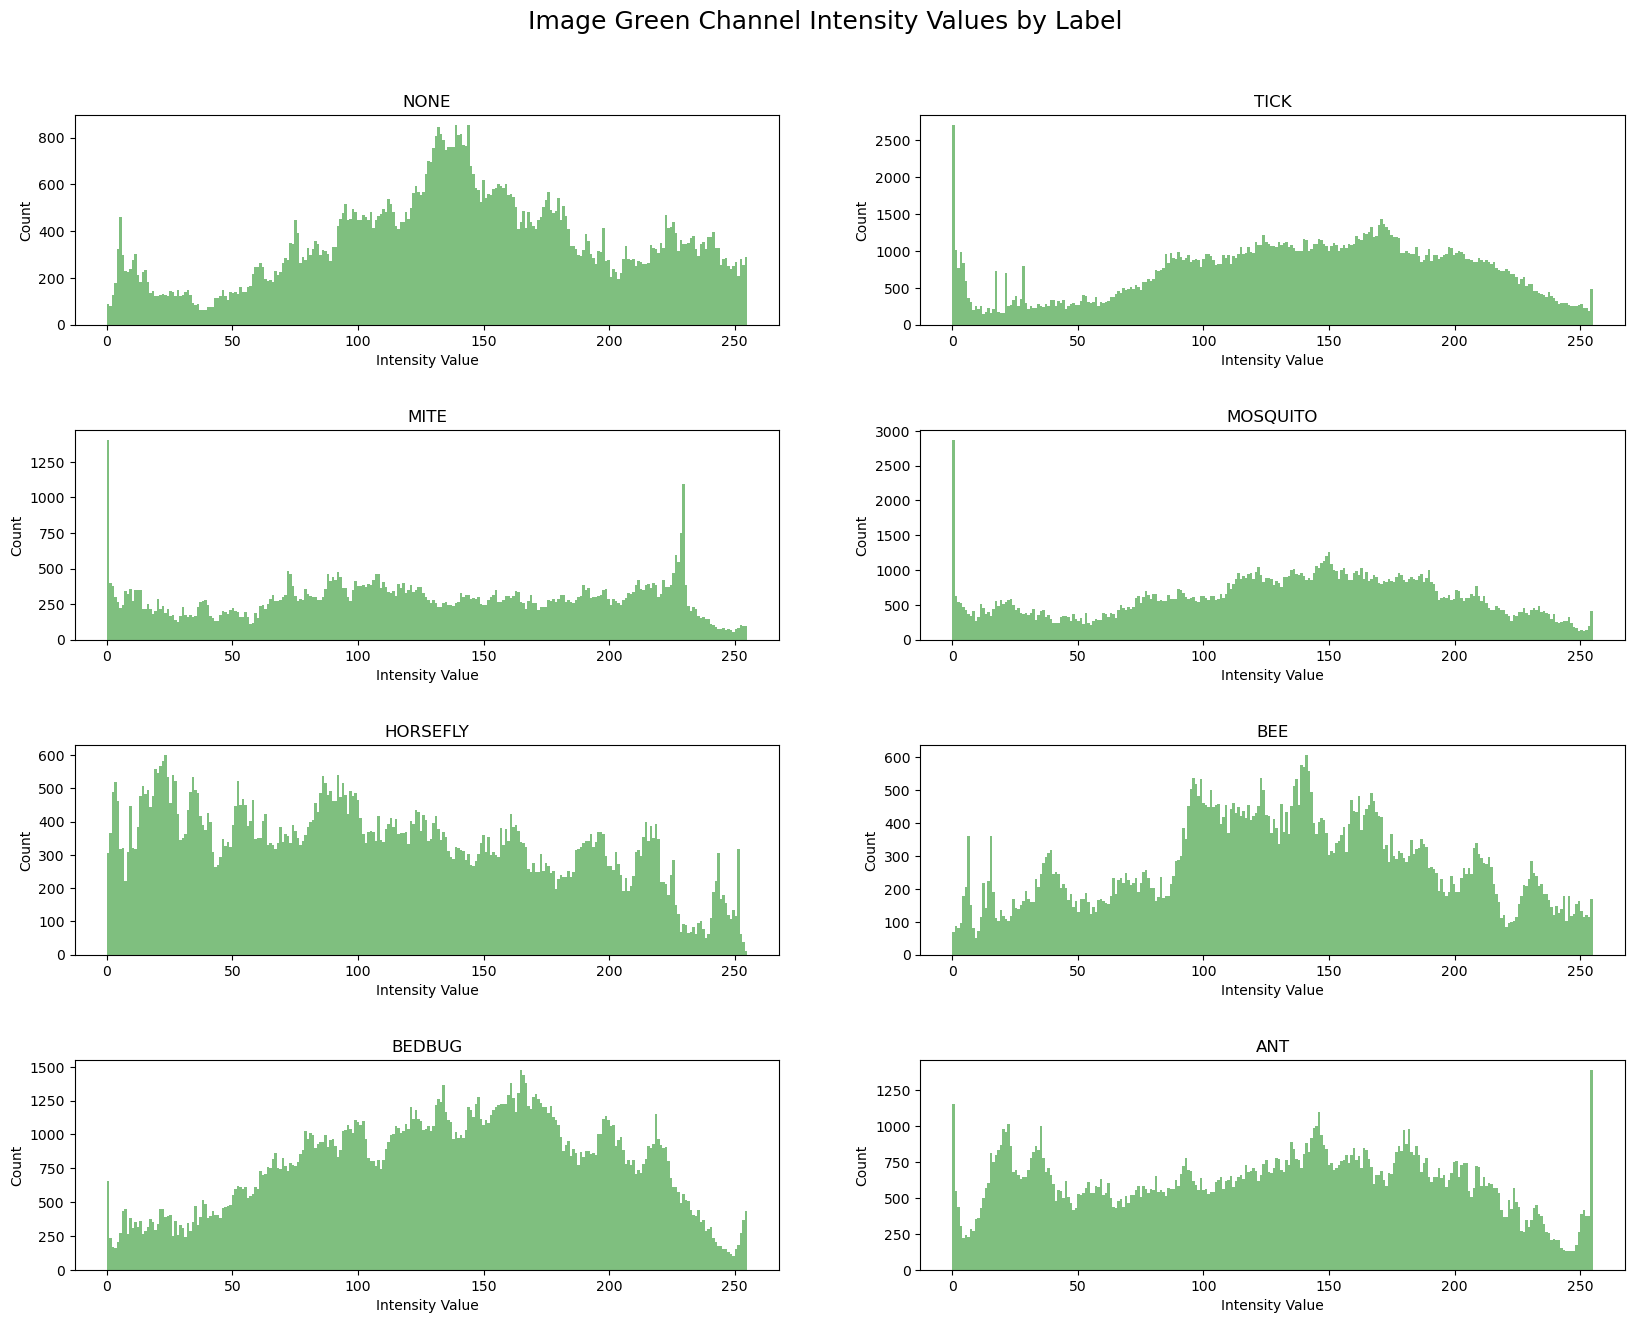

In [8]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Green Channel Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals_g = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals_g = np.append(img_vals_g, img_array_subset[idx, :, 1].ravel())

    ax.hist(img_vals_g, bins=256, color="green", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

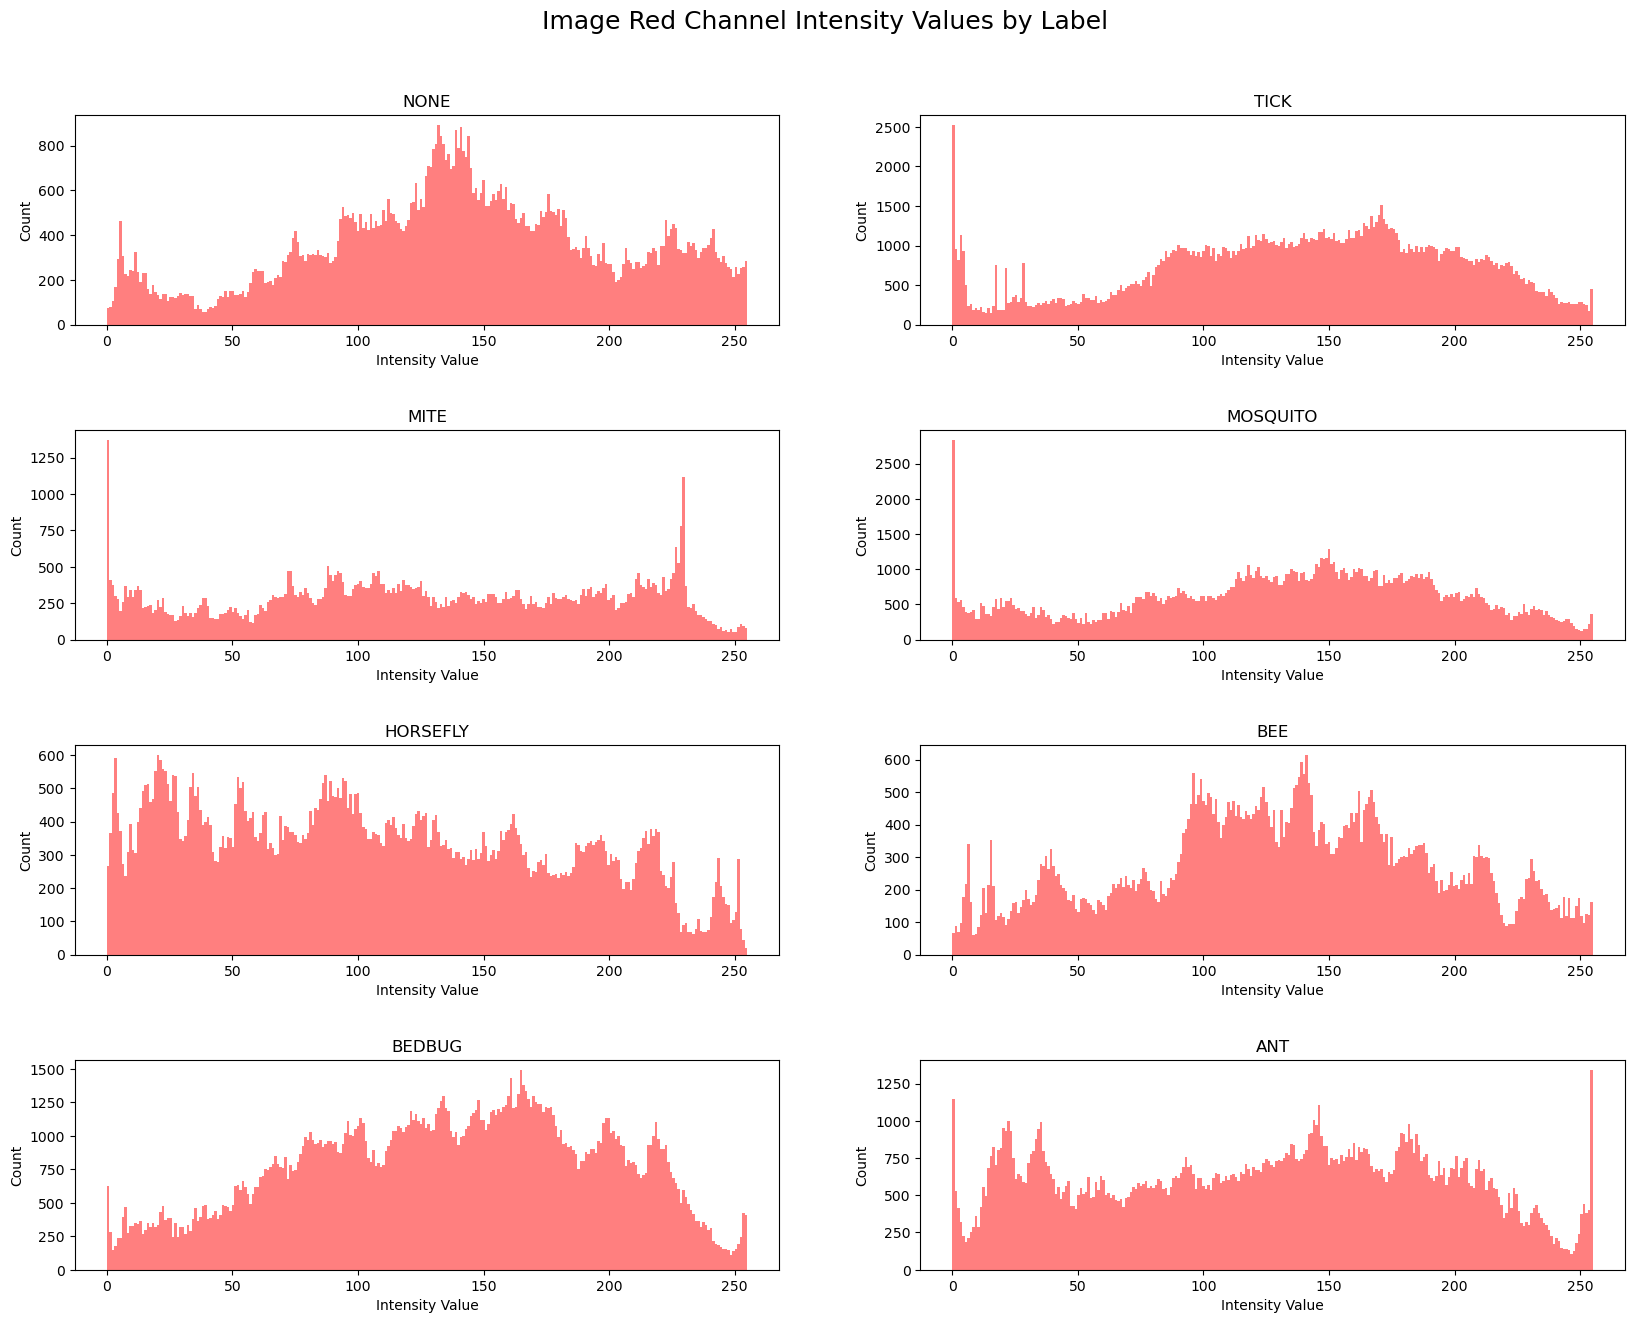

In [9]:
# Plot intensity values by label
labels = metadata["label"].unique()

fig, axs = plt.subplots(nrows=int(len(labels)/2), ncols=2, figsize=(20, 15))
fig.suptitle("Image Red Channel Intensity Values by Label", fontsize=18, y=0.95)
plt.subplots_adjust(hspace=0.5)

for label, ax in zip(labels, axs.ravel()):
    # Subset img array to each label
    img_array_subset = img_array[metadata.loc[metadata.label == label].index]
    # Prepare arrays for channel values
    img_vals_r = np.empty(0)
    
    # Append image label subset values to channel arrays
    for idx, img in enumerate(img_array_subset):
        img_vals_r = np.append(img_vals_r, img_array_subset[idx, :, 2].ravel())

    ax.hist(img_vals_r, bins=256, color="red", alpha=0.5)
    ax.set_title(label.upper())
    ax.set_xlabel("Intensity Value")
    ax.set_ylabel("Count")

It looks like there is no clear indication that color intensity value of the entire image has a clear impact on the class, but rather that the overall intensity is different across classes. For example, the `ant` class has a large number of high intensity values across all channels. This could be a result of images being taken in highly lit environments. Generally, the distribution of intensity values are similar in shape across each channel for every class. 

## Example Augmentations

OpenCV reads images in differently to how matplotlib displays them, so for the purposes of displaying example images we'll have to rearrange the channels manually. In modelling, however, this won't be neccessary. But in order to assess certain augmentations, we need to see how it looks in RGB rather than BGR as we won't be able to evaluate it properly otherwise. 

Following the output of the below, augmentations selected as reasonable to use are:
 1. Flip left to right
 2. Flip up to down
 3. Gaussian Blur / Average Blur
 4. MotionBlur
 5. DefocusBlur
 6. ZoomBlur
 7. MultiplyBrightness
 8. MultiplySaturation
 9. Grayscale
 10. GammaContrast
 11. SigmoidContrast / LinearContrast
 12. Affine
 13. TranslateX
 14. TranslateY
 15. Rotate
 16. ShearX
 17. ShearY
 18. GaussianNoise / ShotNoise / SpeckleNoise / ImpulseNoise
 19. Contrast
 20. Brightness
 21. Saturate
 22. EnhanceColor? (Low values)
 23. EnhanceContrast
 24. EnhanceBrightness
 25. EnhanceSharpness
 26. AdditiveGaussianNoise / AdditiveLaplaceNoise / AdditivePoissonNoise / ImpulseNoise
 27. Cutout
 28. Dropout / CoarseDropout / SaltAndPepper

In [10]:
# Get example image
example_img = img_array[65][...,::-1]

Example images


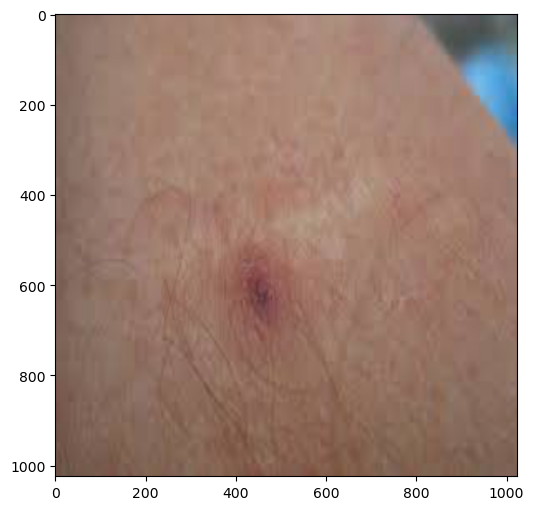

In [11]:
print("Example images")
display_img(example_img)

### Horizontal Flip

In [12]:
def display_img_aug(img, aug, *args, **kwargs):
    """
    Displays input image alongside augmented image.
    
    Parameters
    ----------
    img : np.array
        Original image to augment.
    aug : function
        imgaug.augmenters function to augment img with.
    
    Returns
    -------
    plt.figure
    """
        
    seq = A.Compose([aug(*args, **kwargs)])
    img_aug = seq(image=img)
    images_aug = np.concatenate([np.expand_dims(img, axis=0), np.expand_dims(img_aug["image"], axis=0)])
    
    for img in images_aug:
        display_img(img)

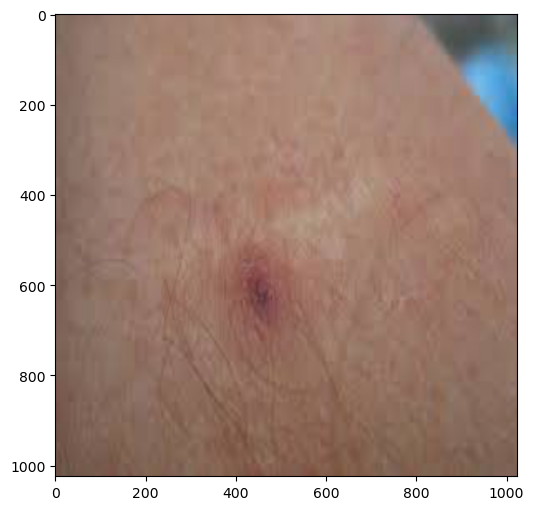

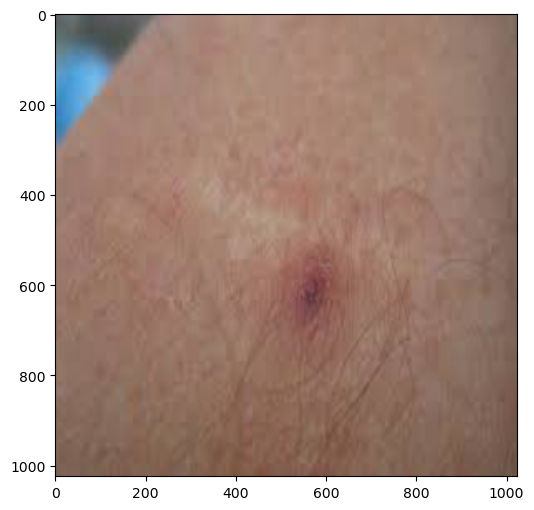

In [13]:
display_img_aug(example_img, A.HorizontalFlip, p=1.0)

### Vertical Flip

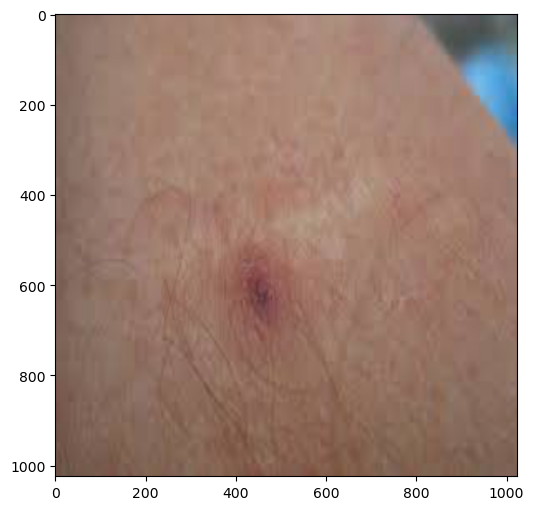

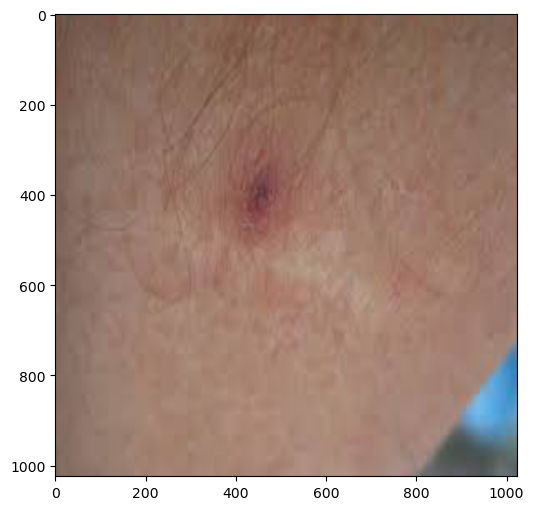

In [14]:
display_img_aug(example_img, A.VerticalFlip, p=1)

### Gaussian Blur

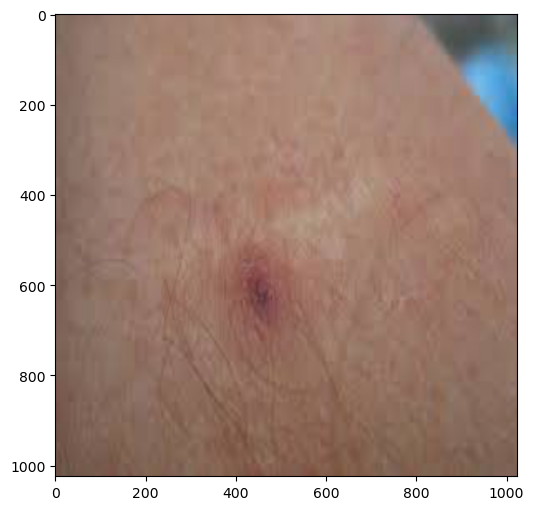

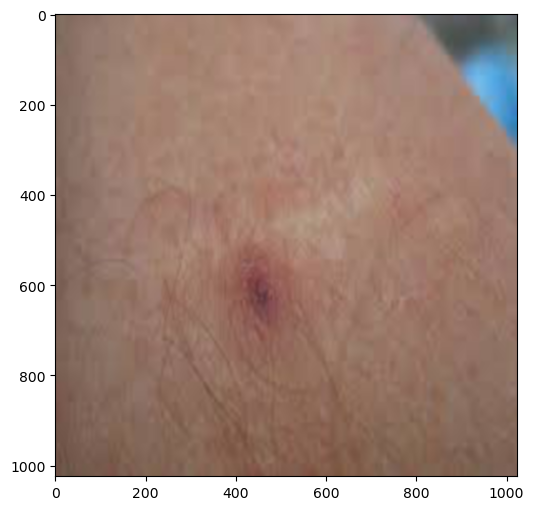

In [15]:
display_img_aug(example_img, A.GaussianBlur, p=1.0, sigma_limit=3)

### MotionBlur

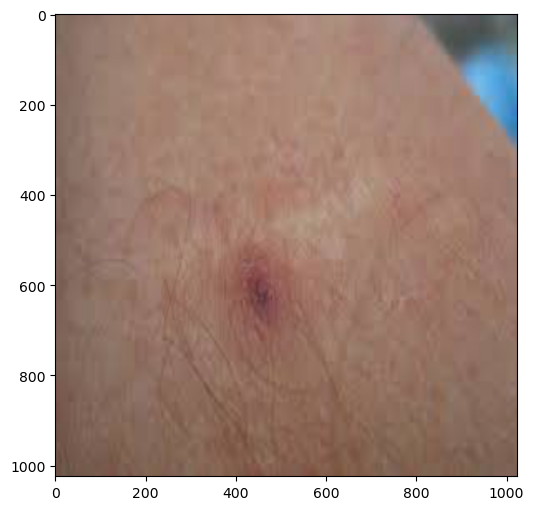

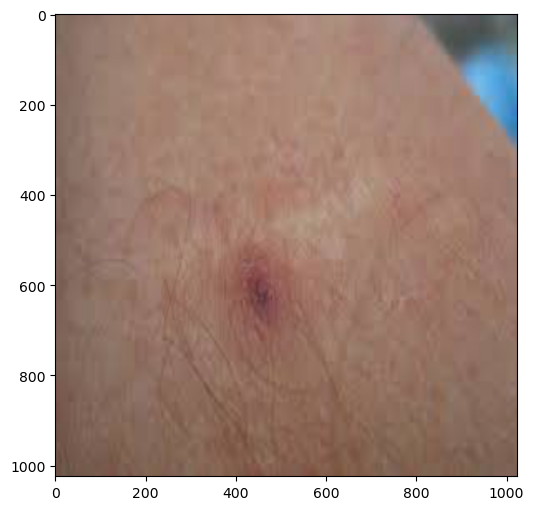

In [16]:
display_img_aug(example_img, A.MotionBlur, blur_limit=7)

### Grayscale

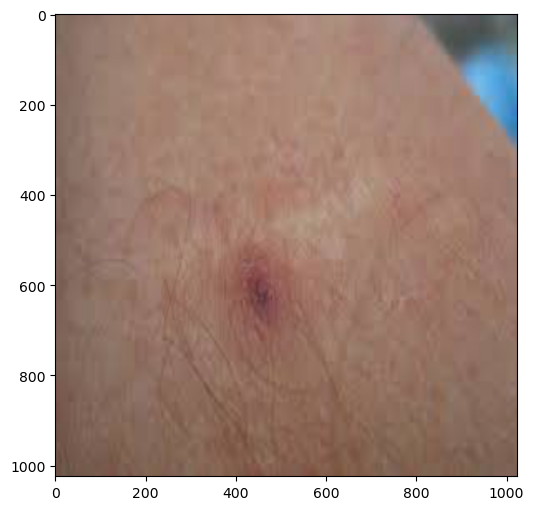

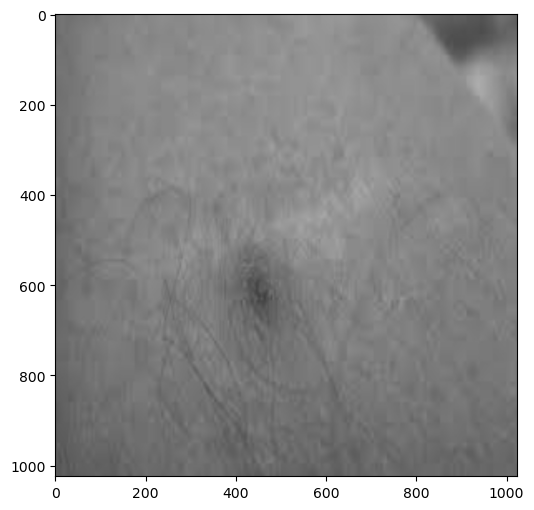

In [17]:
display_img_aug(example_img, A.ToGray, p=1.0)

### Affine

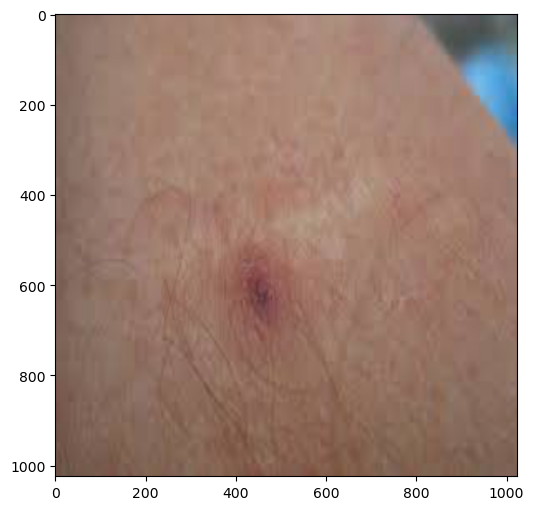

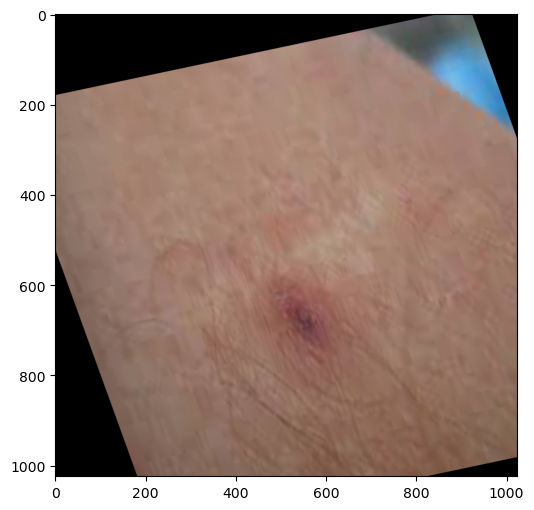

In [18]:
display_img_aug(example_img, A.Affine, p=1.0)

### Pixel Dropout

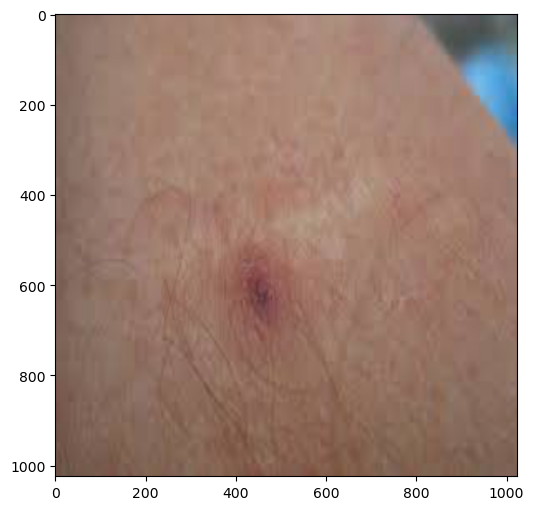

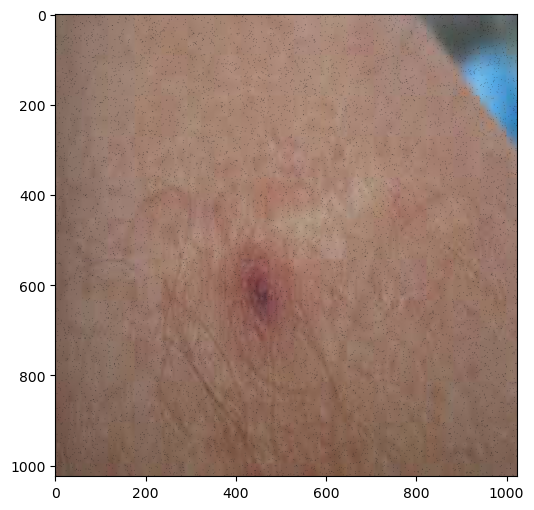

In [19]:
display_img_aug(example_img, A.PixelDropout, p=1.0)

### Coarse Dropout

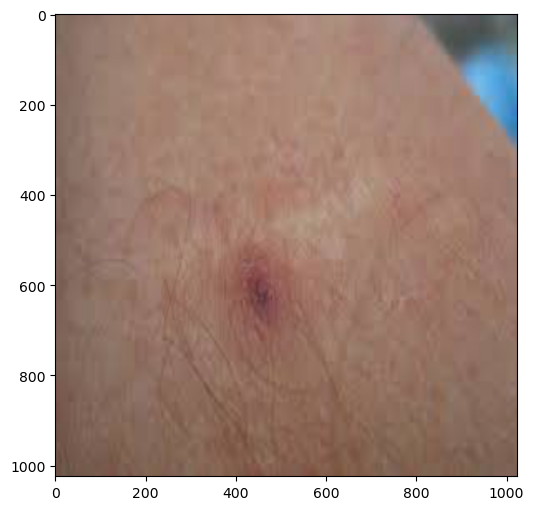

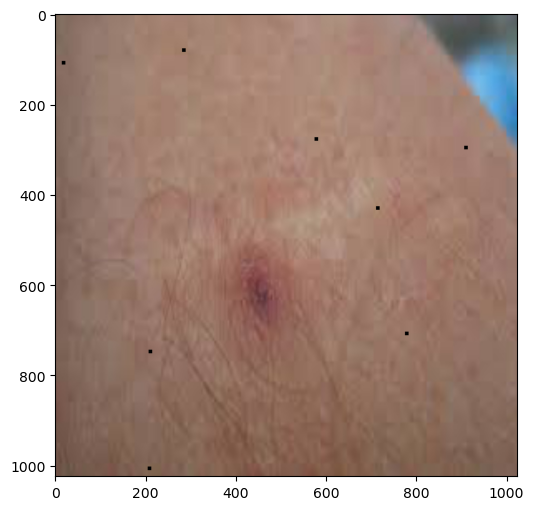

In [20]:
display_img_aug(example_img, A.CoarseDropout, p=1.0)